# Classificação de Imagens usando Transfer Learning

Neste notebook vamos realizar a classificação de um conjunto de imagens utilizando a técnica de Transfer Learning.

In [ ]:
# Source: https://kaggle.com/paultimothymooney/blood-cells

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers import BatchNormalization

import numpy as np
import pandas as pd


Primeiramente, vamos verificar se existe uma GPU em uso:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
tf.test.is_gpu_available() # True/False

2.6.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

A saída esperada é True! 

Agora vamos verificar qual GPU está alocada:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Sep 17 18:58:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |    220MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Dataset

Vamos baixar o dataset "Blood Cell" que contém um total de  12.500, ou seja, 3.000 imagens de 4 tipos de células sanguíneas: Eosinophil, Lymphocyte, Monocyte, and Neutrophil.

Verifique mais informações [neste link](https://www.kaggle.com/paultimothymooney/blood-cells).

In [ ]:
!pip install -U gdown

In [ ]:
# https://drive.google.com/file/d/19yVw1-psTx5jTJup_kzT0yYox1xxUgCN/view?usp=sharing
!gdown --id 19yVw1-psTx5jTJup_kzT0yYox1xxUgCN

Downloading...
From: https://drive.google.com/uc?id=1LlUi5jjAlzQW731MG1iZsxbucIBmCSPE
To: /content/blood_cell_images.zip
113MB [00:01, 106MB/s] 


In [ ]:
from zipfile import ZipFile
with ZipFile('blood_cell_images.zip', 'r') as f:
   f.extractall('data')

In [ ]:
train_path = 'data/dataset2-master/dataset2-master/images/TRAIN'
val_path = 'data/dataset2-master/dataset2-master/images/TEST'


In [ ]:
import os
classes = os.listdir(val_path)
os.listdir(val_path)

['LYMPHOCYTE', 'NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE']

In [ ]:
from glob import glob
folders = glob(train_path + '/*')
k = len(folders)
print(f"Number of classes: {k}")

Number of classes: 4


Esse dataset possui 4 classes: EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL

# Ploting Images

Vamos ver alguns exemplos das imagens.

In [ ]:
from glob import glob 
train_image_files = glob(train_path + "/*/*.jp*g")
validation_image_files = glob(val_path + "/*/*.jp*g")
print(f"Number of Training samples: {len(train_image_files)}")
print(f"Number of Validation samples: {len(validation_image_files)}")

Number of Training samples: 9957
Number of Validation samples: 2487


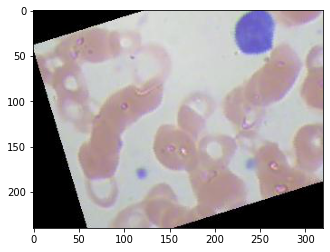

In [ ]:
# Display a image 
from matplotlib import pyplot as plt
from keras.preprocessing import image
plt.imshow(image.img_to_array(image.load_img(train_image_files[5])).astype('uint8'))
plt.show()

# Generators

Vamos criar os generators, que são responsáveis por carregar as imagens na memória e realizar quaisquer transformações necessárias. Verifique a documentação oficial [neste link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = [224, 224]

In [ ]:
# Source https://www.kaggle.com/shilpagopal/resnet50-classifier
from keras.preprocessing.image import ImageDataGenerator
# Creating data generator object with the same preprocessing done in the Resnet
data_gen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

test_generator = data_gen.flow_from_directory(val_path, target_size=IMAGE_SIZE)

train_generator = data_gen.flow_from_directory(train_path,
                                              target_size=IMAGE_SIZE,
                                              shuffle=True,
                                              batch_size=BATCH_SIZE)

val_generator = data_gen.flow_from_directory(val_path,
                                             target_size=IMAGE_SIZE,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

Found 2487 images belonging to 4 classes.
Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


# Download ResNet Model

Vamos baixar o modelo ResNet50 treinado no dataset ImageNet. Outros modelos podem ser observados [neste link](https://keras.io/api/applications/).

In [ ]:
# https://keras.io/api/applications/resnet/
resnet_model = tf.keras.applications.ResNet50(
    weights="imagenet", 
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Método de Transfer Learning

Vamos utilizar o método de transfer learning para adaptar o modelo baixado para nossa tarefa de classificação.

Primeiro, vamos criar um novo modelo, do tipo sequencial. Em seguida, vamos uma camada AveragePooling e outra camada densa. Lembrando que a última camada será responsável por fazer a classificação da imagem. Para isso, essa última camada deve conter um número de neurônios igual ao número de classes do dataset.

In [ ]:
for layer in resnet_model.layers:
    layer.trainable = False

x = keras.layers.Flatten()(resnet_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(len(classes), activation='softmax')(x)

model = keras.models.Model(inputs=resnet_model.input, outputs=predictions)

In [ ]:
'''
model = Sequential()
model.add(resnet_model)
#model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))
'''

Agora, vamos mudar nosso novo modelo sequencial, configurando cada camada como "non-trainable". Dessa forma, os pesos dessas camadas não serão atualizados durante o processo de treinamento do modelo.

In [ ]:
for layer in model.layers[-3:]:
    layer.trainable = True

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
#from tensorflow.keras.optimizers import Adam 
#opt = Adam(learning_rate=0.01
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate = 0.001)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Training

Agora, vamos iniciar o treinamento do nosso modelo. Lembre-se que, da forma como configuramos as camadas, apenas a última camada será treinada.

In [ ]:
#Defining the parameters
epochs=30

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs = epochs)

Epoch 1/30
78/78 [==============================] - 170s 2s/step - loss: 19.7417 - accuracy: 0.2579 - val_loss: 1.3884 - val_accuracy: 0.2513
Epoch 2/30
78/78 [==============================] - 146s 2s/step - loss: 1.5010 - accuracy: 0.2478 - val_loss: 1.5099 - val_accuracy: 0.2501
Epoch 3/30
78/78 [==============================] - 143s 2s/step - loss: 1.4161 - accuracy: 0.2505 - val_loss: 1.3864 - val_accuracy: 0.2505
Epoch 4/30
78/78 [==============================] - 143s 2s/step - loss: 1.4517 - accuracy: 0.2513 - val_loss: 1.3863 - val_accuracy: 0.2493
Epoch 5/30
78/78 [==============================] - 142s 2s/step - loss: 1.4216 - accuracy: 0.2423 - val_loss: 1.3862 - val_accuracy: 0.2509
Epoch 6/30
78/78 [==============================] - 142s 2s/step - loss: 1.4121 - accuracy: 0.2485 - val_loss: 1.3865 - val_accuracy: 0.2505
Epoch 7/30
78/78 [==============================] - 142s 2s/step - loss: 1.4090 - accuracy: 0.2391 - val_loss: 1.3877 - val_accuracy: 0.2509
Epoch 8/30
7

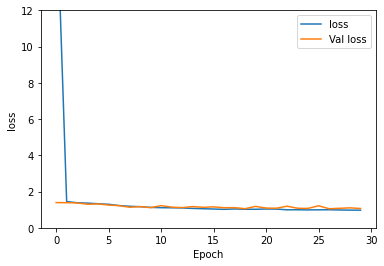

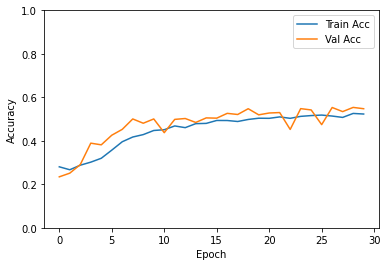

In [ ]:
from matplotlib import pyplot as plt
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    plt.ylim([0,12])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Acc')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Acc')
    plt.ylim([0,1])
    plt.legend()
    plt.show()


plot_history(history)


# Salvando o Modelo

Você pode salvar um modelo inteiro em um único. Para isso, execute o comando a seguir. Para mais informações, verifique [https://www.tensorflow.org/guide/keras/save_and_serialize](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [ ]:
model.save('save_model/resnet_blood_cell_model.h5')


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Para baixar o modelo para seu computador, execute o próximo comando.

In [ ]:
from google.colab import files
files.download('save_model/resnet_blood_cell_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Salvar e baixar todo o modelo pode demorar um pouco. Talvez a melhor opção seja salvar apenas os pesos.

In [ ]:
model.save_weights("save_model/resnet_blood_cell_model_ckpt-")


In [ ]:
!tar -jcvf save_model_resnet_blood_cell.tar.bz save_model

save_model/
save_model/resnet_blood_cell_model.h5
save_model/resnet_blood_cell_model_ckpt-.index
save_model/resnet_blood_cell_model_ckpt-.data-00000-of-00001
save_model/checkpoint


In [ ]:
from google.colab import files
files.download('save_model_resnet_blood_cell.tar.bz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Carregando o Modelo

In [ ]:
load_status = model.load_weights("save_model/resnet_blood_cell_model_ckpt-")
load_status

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("save_model/resnet_blood_cell_model.h5")


# Testing

In [ ]:
tsdata = ImageDataGenerator()
test_data = tsdata.flow_from_directory(directory="./data/dataset2-master/dataset2-master/images/TEST_SIMPLE/", target_size=(220,220))

Found 71 images belonging to 4 classes.


In [ ]:
scores = reconstructed_model.evaluate(test_data)
print("Accuracy: {}".format(scores[1]))


3/3 [==============================] - 0s 76ms/step - loss: 12.4579 - accuracy: 0.7887
Accuracy: 0.7887324094772339


# Matriz de Confusão

In [ ]:
# Extract the labels 

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
      labels[v] = k
labels

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [ ]:
# https://www.kaggle.com/shilpagopal/resnet50-classifier

from sklearn.metrics import confusion_matrix

def get_confusion_matrix(data_path, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in data_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=BATCH_SIZE * 2):
        i += 1
        if i % 1000 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(train_image_files))
print(cm)
validation_cm = get_confusion_matrix(val_path, len(validation_image_files))
print(validation_cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
[[1352 1111    0   34]
 [ 168 2311    0    4]
 [ 996 1434   16   32]
 [1038 1202    0  259]]
Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[238 367   0  18]
 [116 504   0   0]
 [361 244   0  15]
 [272 291   0  61]]


In [ ]:
test_path = "./data/dataset2-master/dataset2-master/images/TEST_SIMPLE/"
test_cm = get_confusion_matrix(test_path, len(validation_image_files))
print(test_cm)

Generating confusion matrix 2487
Found 71 images belonging to 4 classes.
[[110 310   0  48]
 [ 19 196   0   1]
 [ 60  61   0  23]
 [338 784   0 606]]


In [ ]:
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def y2indicator(Y):
    K = len(set(Y))
    N = len(Y)
    I = np.empty((N, K))
    I[np.arange(N), Y] = 1
    return I

Confusion matrix, without normalization
[[1352 1111    0   34]
 [ 168 2311    0    4]
 [ 996 1434   16   32]
 [1038 1202    0  259]]


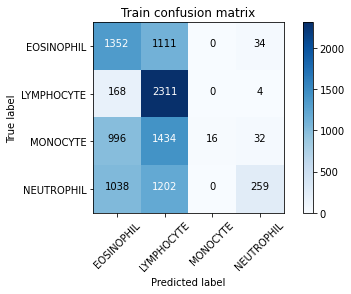

Confusion matrix, without normalization
[[238 367   0  18]
 [116 504   0   0]
 [361 244   0  15]
 [272 291   0  61]]


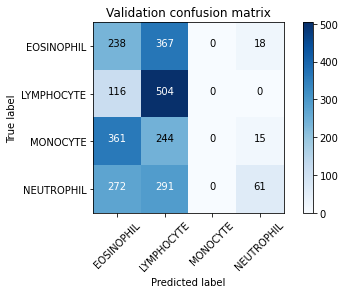

In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(validation_cm, labels, title='Validation confusion matrix')

Confusion matrix, without normalization
[[110 310   0  48]
 [ 19 196   0   1]
 [ 60  61   0  23]
 [338 784   0 606]]


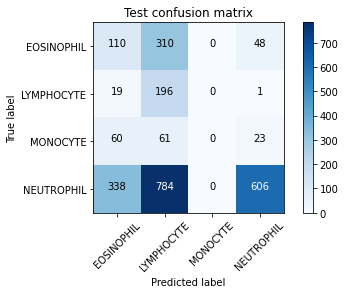

In [ ]:
plot_confusion_matrix(test_cm, labels, title='Test confusion matrix')